In [2]:
import os
import numpy as np
import pandas as pd
import sklearn
import typing as tp
import re
import matplotlib.pyplot as plt

In [3]:
# https://webpages.uidaho.edu/ui-prmd/

base_data_dir: str = os.path.join('..', 'data', 'SemesterProject')

for parent_dir, folders, files in os.walk(base_data_dir):
    print('\n'.join(files))

Animation.m


m09_s04_positions.txt
m08_s02_positions.txt
m05_s01_positions.txt
m09_s01_positions.txt
m03_s02_positions.txt
m05_s06_positions.txt
m07_s03_positions.txt
m07_s08_positions.txt
m02_s09_positions.txt
m09_s09_positions.txt
m08_s10_positions.txt
m08_s08_positions.txt
m09_s05_positions.txt
m02_s01_positions.txt
m03_s01_positions.txt
m07_s01_positions.txt
m06_s02_positions.txt
m05_s03_positions.txt
m06_s10_positions.txt
m01_s01_positions.txt
m02_s03_positions.txt
m02_s06_positions.txt
m01_s06_positions.txt
m06_s03_positions.txt
m06_s06_positions.txt
m02_s10_positions.txt
m09_s03_positions.txt
m04_s03_positions.txt
m08_s05_positions.txt
m04_s08_positions.txt
m01_s09_positions.txt
m04_s07_positions.txt
m10_s04_positions.txt
m05_s08_positions.txt
m08_s03_positions.txt
m07_s05_positions.txt
m08_s07_positions.txt
m09_s07_positions.txt
m07_s07_positions.txt
m08_s04_positions.txt
m07_s02_positions.txt
m06_s01_positions.txt
m01_s07_positions.txt
m05_s05_positions.txt
m10_s03_positions.

## Constructing Training dataset

In [4]:
def rotate_z(t: np.ndarray) -> np.ndarray:
    # Rotation about Z axis
    ct: np.ndarray = np.cos(t)
    st: np.ndarray = np.sin(t)
    return np.array([[ct, -st, 0], [st, ct, 0], [0, 0, 1]])

def rotate_x(t: np.ndarray) -> np.ndarray:
    ct: np.ndarray = np.cos(t)
    st: np.ndarray = np.sin(t)
    return np.array([[1, 0, 0], [0, ct, -st], [0, st, ct]])

def rotate_y(t: np.ndarray) -> np.ndarray:
    ct: np.ndarray = np.cos(t)
    st: np.ndarray = np.sin(t)
    return np.array([[ct, 0, st], [0, 1, 0], [-st, 0, ct]])

def eulers_2_rot_matrix(x: np.ndarray) -> np.ndarray:
    # EULER_2_ROT_MATRIX transforms a set of euler angles into a rotation  matrix
    # This might need a couple of 0's attached to it.
    gamma_x: np.ndarray = x[0]
    beta_y: np.ndarray = x[1]
    alpha_z: np.ndarray = x[2]

    return rotate_z(alpha_z) * rotate_y(beta_y) * rotate_x(gamma_x)

def movement_name(movement_id: int) -> str:
    # From the original paper (Table 1):
    # https://webpages.uidaho.edu/ui-prmd/Vakanski%20et%20al%20(2018)%20-%20A%20data%20set%20of%20human%20body%20movements%20for%20physical%20rehabilitation%20exercises.pdf
    match movement_id:
        case 1:
            return 'deep_squat'
        case 2:
            return 'hurdle_step'
        case 3:
            return 'inline_lunge'
        case 4:
            return 'side_lunge'
        case 5:
            return 'sit_to_stand'
        case 6:
            return 'standing_active_straight_leg_raise'
        case 7:
            return 'standing_shoulder_abduction'
        case 8:
            return 'standing_shoulder_extension'
        case 9:
            return 'standing_shoulder_internal-external_rotation'
        case 10:
            return 'standing_shoulder_scaption'
        case _:
            return 'ERROR'


def rotate_joint(curr_joint: np.ndarray, prev_joint_angle: np.ndarray, prev_joint_position: np.ndarray) -> np.ndarray:
    rotate_current_joint: np.ndarray = eulers_2_rot_matrix(prev_joint_angle)

    return (rotate_current_joint @ curr_joint.T).T + prev_joint_position.reshape((1, -1))


In [10]:
# I think I'm gonna work with the Kinect since that one is one I can get a hold of if I need to.

# Going based on animation.m from the source.

kinect_pos_base_dir: str = os.path.join(base_data_dir, 'Movements', 'Kinect', 'Positions')
kinect_ang_base_dir: str = os.path.join(base_data_dir, 'Movements', 'Kinect', 'Angles')

parser_pattern: re.Pattern = re.compile(r'm(?P<movement>\d{2})_s(?P<subject>\d{2}).*s\.txt')

correct_movements: tp.List[tp.Dict[str, tp.Union[np.ndarray, int]]] = []

for fp in os.listdir(kinect_pos_base_dir):
    parsed_match: re.Match = parser_pattern.match(fp)
    movement_id: int = int(parsed_match['movement'])
    subject_id: int = int(parsed_match['subject'])

    print(f'Currently processing movement id {movement_id} / subject id {subject_id}')

    pos_path: str = os.path.join(kinect_pos_base_dir, f'm{movement_id:02}_s{subject_id:02}_positions.txt')
    ang_path: str = os.path.join(kinect_ang_base_dir, f'm{movement_id:02}_s{subject_id:02}_angles.txt')

    if not os.path.exists(pos_path) or not os.path.exists(ang_path):
        continue

    pos_array: np.ndarray = np.loadtxt(pos_path)
    ang_array: np.ndarray = np.loadtxt(ang_path)

    n_frames: int = pos_array.shape[0]

    skeleton_pos: np.ndarray = np.zeros((22, 3, n_frames))
    skeleton_ang: np.ndarray = np.zeros((22, 3, n_frames))
    pos_array1: np.ndarray = pos_array.T
    ang_array1: np.ndarray = ang_array.T

    for i in range(n_frames):
        skeleton_pos[:, :, i] = pos_array1[:, i].reshape((3, 22)).T
        skeleton_ang[:, :, i] = ang_array1[:, i].reshape((3, 22)).T



    """
    % 1 Waist (absolute)
% 2 Spine
% 3 Chest
% 4 Neck
% 5 Head
% 6 Head tip
% 7 Left collar
% 8 Left upper arm
% 9 Left forearm
% 10 Left hand
% 11 Right collar
% 12 Right upper arm
% 13 Right forearm
% 14 Right hand
% 15 Left upper leg
% 16 Left lower leg
% 17 Left foot
% 18 Left leg toes
% 19 Right upper leg
% 20 Right lower leg
% 21 Right foot
% 22 Right leg toes
    """

    joint_connections: np.ndarray = np.array([[4, 6, 5, 3, 2, 3, 7, 8, 9, 3, 11,  12, 13, 1,  15, 16, 17, 1,  19, 20, 21], [3, 5, 3, 2, 1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]])

    skeleton: np.ndarray = np.zeros((22, 3, n_frames))

    for i in range(n_frames):
        joint: np.ndarray = skeleton_pos[:, :, i]
        joint_angle: np.ndarray = np.deg2rad(skeleton_ang[:, :, i])

        for j in range(1, 22):
            joint_rotation: np.ndarray = rotate_joint(joint[j, :], joint_angle[j - 1], joint[j - 1, :])

            joint[j, np.newaxis] = joint_rotation

        skeleton[:, :, i] = joint

    correct_movements.append({'movement_id': movement_id, 'subject_id': subject_id, 'positions': pos_array, 'angles': ang_array, 'positions_path': pos_path, 'angles_path': ang_path, 'skeleton': skeleton})

df: pd.DataFrame = pd.DataFrame.from_records(correct_movements)

df['movement_name'] = df['movement_id'].map(movement_name)
df['reshaped_skeleton'] = df['skeleton'].apply(lambda s: s.reshape((-1, 22, 3)))

df

Currently processing movement id 9 / subject id 4
Currently processing movement id 8 / subject id 2
Currently processing movement id 5 / subject id 1
Currently processing movement id 9 / subject id 1
Currently processing movement id 3 / subject id 2
Currently processing movement id 5 / subject id 6
Currently processing movement id 7 / subject id 3
Currently processing movement id 7 / subject id 8
Currently processing movement id 2 / subject id 9
Currently processing movement id 9 / subject id 9
Currently processing movement id 8 / subject id 10
Currently processing movement id 8 / subject id 8
Currently processing movement id 9 / subject id 5
Currently processing movement id 2 / subject id 1
Currently processing movement id 3 / subject id 1
Currently processing movement id 7 / subject id 1
Currently processing movement id 6 / subject id 2
Currently processing movement id 5 / subject id 3
Currently processing movement id 6 / subject id 10
Currently processing movement id 1 / subject id 

,movement_id,subject_id,positions,angles,positions_path,angles_path,skeleton,movement_name,reshaped_skeleton
0,9,4,"[[-1.19602, 90.36825, -246.48466, 0.0, 31.2241...","[[0.26788, -1.22513, -2.17909, 1.84751, -2.622...",../data/SemesterProject/Movements/Kinect/Posit...,../data/SemesterProject/Movements/Kinect/Angle...,"[[[-1.19602, -1.19602, -1.19602, -1.19651, -1....",standing_shoulder_internal-external_rotation,"[[[-1.19602, -1.19602, -1.19602], [-1.19651, -..."
1,8,2,"[[-9.84419, 89.37624, -248.33688, 0.0, 34.8875...","[[-1.45122, 44.39004, 1.83937, 1.1145, 9.35349...",../data/SemesterProject/Movements/Kinect/Posit...,../data/SemesterProject/Movements/Kinect/Angle...,"[[[-9.84419, -9.7477, -9.70698, -9.74106, -9.6...",standing_shoulder_extension,"[[[-9.84419, -9.7477, -9.70698], [-9.74106, -9..."
2,5,1,"[[-8.56437, 83.45974, -232.84654, -1e-05, 28.8...","[[-3.30185, 0.20368, -1.1139, 1.53722, -0.5299...",../data/SemesterProject/Movements/Kinect/Posit...,../data/SemesterProject/Movements/Kinect/Angle...,"[[[-8.56437, -8.53799, -8.53688, -8.53193, -8....",sit_to_stand,"[[[-8.56437, -8.53799, -8.53688], [-8.53193, -..."
3,9,1,"[[-8.83632, 80.3436, -242.36078, 0.0, 29.48024...","[[-0.54978, 0.36297, -3.48858, 1.76799, -3.326...",../data/SemesterProject/Movements/Kinect/Posit...,../data/SemesterProject/Movements/Kinect/Angle...,"[[[-8.83632, -8.83632, -8.83632, -8.83632, -8....",standing_shoulder_internal-external_rotation,"[[[-8.83632, -8.83632, -8.83632], [-8.83632, -..."
4,3,2,"[[-31.65818, 84.01022, -257.20483, 0.0, 30.391...","[[4.4155, 33.06184, 1.72114, 1.83948, 4.36797,...",../data/SemesterProject/Movements/Kinect/Posit...,../data/SemesterProject/Movements/Kinect/Angle...,"[[[-31.65818, -31.6587, -31.66449, -31.66845, ...",inline_lunge,"[[[-31.65818, -31.6587, -31.66449], [-31.66845..."
...,...,...,...,...,...,...,...,...,...
95,6,5,"[[-10.08699, 93.21901, -256.08487, 0.0, 34.621...","[[0.0818, -32.61801, -4.83653, 1.4331, -10.998...",../data/SemesterProject/Movements/Kinect/Posit...,../data/SemesterProject/Movements/Kinect/Angle...,"[[[-10.08699, -10.07554, -10.03018, -9.86916, ...",standing_active_straight_leg_raise,"[[[-10.08699, -10.07554, -10.03018], [-9.86916..."
96,10,7,"[[-4.12946, 77.23314, -252.23236, -1e-05, 30.2...","[[3.05714, -2.38786, -1.08423, 1.72285, 0.0411...",../data/SemesterProject/Movements/Kinect/Posit...,../data/SemesterProject/Movements/Kinect/Angle...,"[[[-4.12946, -4.14023, -4.14283, -4.14757, -4....",standing_shoulder_scaption,"[[[-4.12946, -4.14023, -4.14283], [-4.14757, -..."
97,2,4,"[[-3.83258, 92.3698, -223.88351, 0.0, 31.3132,...","[[2.04479, -5.4409, -2.18145, 1.73012, -0.5233...",../data/SemesterProject/Movements/Kinect/Posit...,../data/SemesterProject/Movements/Kinect/Angle...,"[[[-3.83258, -3.83258, -3.83258, -3.83382, -3....",hurdle_step,"[[[-3.83258, -3.83258, -3.83258], [-3.83382, -..."
98,3,6,"[[-14.55854, 84.63128, -262.7222, 0.0, 27.5640...","[[4.33697, -30.61813, -2.31491, 1.44513, -17.8...",../data/SemesterProject/Movements/Kinect/Posit...,../data/SemesterProject/Movements/Kinect/Angle...,"[[[-14.55854, -14.78632, -14.92953, -15.16792,...",inline_lunge,"[[[-14.55854, -14.78632, -14.92953], [-15.1679..."


In [11]:
df['reshaped_skeleton'].apply(lambda s: s.shape)

0     (706, 22, 3)
1     (802, 22, 3)
2     (945, 22, 3)
3     (898, 22, 3)
4     (856, 22, 3)
          ...     
95    (866, 22, 3)
96    (564, 22, 3)
97    (845, 22, 3)
98    (740, 22, 3)
99    (841, 22, 3)
Name: reshaped_skeleton, Length: 100, dtype: object

In [16]:
skeleton_to_animate: np.ndarray = df.iloc[0]['reshaped_skeleton']

np.save(os.path.join('..', 'data', 'SemesterProject', 'skeleton_to_animate'), skeleton_to_animate)

skeleton_to_animate.shape, joint_connections.shape

((706, 22, 3), (2, 21))

In [13]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

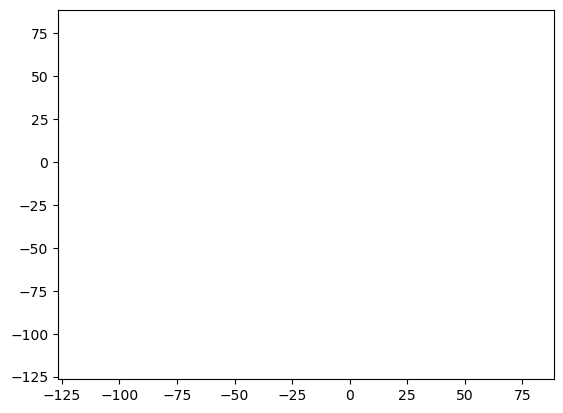

In [15]:
fig, ax = plt.subplots()

curr_plot = ax.plot([], [], 'r.')

max_x: float = np.max(skeleton_to_animate[:, :, 2])
min_x: float = np.min(skeleton_to_animate[:, :, 2])

max_y: float = np.max(skeleton_to_animate[:, :, 1])
min_y: float = np.min(skeleton_to_animate[:, :, 1])

def init():
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    return curr_plot

# for i in range(skeleton_to_animate.shape[0]):
def animate(frame_idx: int):
    joint: np.ndarray = skeleton_to_animate[frame_idx]
    n_joints: int = joint.shape[0]
    x: np.ndarray = joint[:, 2]
    y: np.ndarray = joint[:, 1]

    curr_plot.scatter(x, y, 'r.', marker_size=15)

    for joint_idx in range(joint_connections.shape[1]):
        point1: float = joint[joint_connections[0, joint_idx], :]
        point2: float = joint[joint_connections[1, joint_idx], :]

        # line([point1(3),point2(3)], [point1(1),point2(1)], [point1(2),point2(2)], 'LineWidth',2);
        curr_plot.line([point1[2], point2[2]], [point1[0], point2[0]], line_width=2)

animation_obj = FuncAnimation(fig, animate, frames=skeleton_to_animate.shape[0], init_func=init, blit=True)

plt.show()